# PyMC Markov Chain Monte Carlo Benzene Price Forecasting

## 0.0 Notes and Explainations

This notebook uses SQL to query::
* lyb-sql-devdacore-002.5bff9fcb8330.database.windows.net 
    * To extract the information contained in the t-code ZMRRELPO
* lyb-sql-prddacore-002.bed79ae4ef8b.database.windows.net
    * To extract ZEMA IHS data
    * To extract ZEMA ICIS data

### 0.1 Environment setup

This workbook utilizes the py37_benzene environment which can be installed via the Anaconda Prompt from your local repo sync by running:
> conda env create -f py37_benzene_mcmc.yml

This .yml file is stored in the root scripts directory

## 1.0 Prepare Workspace

### 1.1 Import Standard Libraries and configure runtime parameters

In [114]:
##
# Import Basic Python DS Libraries 
import pandas as pd     # Standard data science package
import numpy as np      # Additional numerical functions
#import dtale
import warnings
warnings.filterwarnings('ignore')

##
# Import Advanced Python DS Libraries
#import missingno as msno    # Missing value toolbox
#from pandas_profiling import ProfileReport     # Integrated/deep reporting, resource intensive
#from statsmodels.tsa.stattools import adfuller  # Statistical test for stationary data

##
# Import Plotting Libraries
import matplotlib.pyplot as plt                # Full featured plotting toolbox
plt.rcParams['figure.figsize'] = (25,8)
#import plotly.graph_objects as go               #Plotly GO toolbox
#import plotly.express as px                    # Plotly Express plotting toolbox
#import plotly.io as pio                        # Addtional Controls for plotly to allow visuals within VSCode Notebook
#import seaborn as sns       # Seaborn plotting toolbox

##
# Import Operating System Interface Libraries
import os       # operating system interface
import sys
#import calendar
#import datetime as dt
from datetime import datetime, timedelta, date

##
# Setup packages for sending messages
#import requests
#import json

##
# Import timing function(s)
from time import perf_counter
import datetime

## 
# Import PyMC package
import arviz as az
import pymc as pm
import scipy as sp

In [2]:
# Configure Libraries
#pio.renderers.default = "notebook_connected" # Configure plotly to print within VSCode environment
#pio.renderers.default = "vscode"


### 1.2 Import Custom Functions

In [3]:
# Define location for custom functions
module_path = os.path.abspath(os.path.join('../Functions'))

# Verify it's accessible for loading
if (module_path not in sys.path) & (os.path.isdir(module_path)):
    sys.path.append(module_path)
    print('Added', module_path, 'to system paths')

elif (module_path in sys.path) & (os.path.isdir(module_path)):
    print(module_path, 'ready to be used for import')

else:
    print(module_path, 'is not a valid path')

# Import Custom Functions
try: from multi_plot import *; print('Loaded multiplot')
except: print('failed to load multi_plot')

try: from StationaryTools import *; print('Loaded StationaryTools')
except: print('Failed to load StationaryTools')

try: from RegressionTools import *; print('Loaded RegressionTools')
except: print('Failed to load RegressionTools')

#try: from NaiveForecasting import *; print('Loaded NaiveTools')
#except: print('Failed to load NaiveTools')

try: from ModelingTools import *; print("Loaded ModelingTools")
except: print('ModelingTools failed to load')

try: from  sk_ts_modelfit import *; print('Loaded sk_ts_modelfit')
except: print('Failed to load sk_ts_modelfit')

Added c:\Users\baanders\Documents\Benzene Forecasting\Scripts\Functions to system paths
failed to load multi_plot
Failed to load StationaryTools
Failed to load RegressionTools
ModelingTools failed to load
Failed to load sk_ts_modelfit


### 1.3 Configure messaging

In [4]:
url = 'https://lyondellbasell.webhook.office.com/webhookb2/0b44f724-4c38-4322-af43-1cc8a79b2240@fbe62081-06d8-481d-baa0-34149cfefa5f/IncomingWebhook/7d6ffad65b414df9bd9bf5fa64da44b2/76b3b453-0a85-40ff-a5d7-15d042decdf6'

#payload = {
#    "text": "Sample alert text"
#}
#headers = {
#    'Content-Type': 'application/json'
#}
#response = requests.post(url, headers=headers, data=json.dumps(payload))
#print(response.text.encode('utf8'))

## 2.0 Import Data

In [5]:
# Define default storage location for files
dataroot = '../../Data/Parquet/SKLearn Data/'
ifilename = 'weekly_for_modeling'

In [6]:
# Check if data location above exists. If it does import dataset.
# All datasets imported with name df so that we can generically 
filename = dataroot+ifilename+'.parquet'
if os.path.isdir(dataroot):
    df_p = pd.read_parquet(filename)#, engine='fastparquet')
    print(ifilename + ' dataset loaded with shape', df_p.shape, 'and', df_p.isna().sum().sum(), 'NaN values')
    
else:
    print('Storage location does not exist. Please update directory and try again.')

weekly_for_modeling dataset loaded with shape (374, 21574) and 48174 NaN values


In [7]:
# Find newest date stored in df_p
newest_date = max(df_p.columns.levels[0])
print(f'Newest run_date is: {newest_date}')

Newest run_date is: 2022-06-03


In [8]:
# Extract df as only newest model date
df = df_p[newest_date]
print(f'Shape of {newest_date} entry is {df.shape}')

Shape of 2022-06-03 entry is (374, 5432)


## 3.0 Data Preparation

### 3.1 Limit Columns to be used in fits

In [9]:
print('Shape before droping columns', df.shape)
df = df.loc[:,~df.columns.str.contains('^USD')]         # Remove columns that start with USD
df = df.loc[:,~df.columns.str.contains('^....USD')]     # Remove columns that start with xxx/USD
df = df.loc[:,~df.columns.str.contains('-CLOSE')]       # Remove columns that contain -CLOSED
df = df.loc[:,~df.columns.str.contains('-HIGH')]        # Remove columns that contain -HIGH
df = df.loc[:,~df.columns.str.contains('-HIGHLOW2')]    # Remove columns that contain -HIGHLOW2
df = df.loc[:,~df.columns.str.contains('-LOW')]         # Remove columns that contain -LOW

print('Shape after droping columns', df.shape)          # Print final shape of df for validation

Shape before droping columns (374, 5432)
Shape after droping columns (374, 1694)


In [10]:
test_cols = [col for col in df if col.startswith('Benzene')]
test_cols

['Benzene CFR Taiwan MAvg (USD/MT)-AVERAGE',
 'Benzene CFR Taiwan Weekly (USD/MT)-AVERAGE',
 'Benzene ENEOS Corporation CP Nomination (USD/MT)-AVERAGE',
 'Benzene ENEOS Corporation CP Settlement (USD/MT)-AVERAGE',
 'Benzene FOB Brazil Weekly (USD/MT)-AVERAGE',
 'Benzene FOB Korea Marker (USD/MT)-AVERAGE',
 'Benzene FOB Korea Marker MAvg (USD/MT)-AVERAGE',
 'Benzene FOB Korea Marker WAvg (USD/MT)-AVERAGE',
 'Benzene FOB Korea Paper BalMo (USD/MT)-AVERAGE',
 'Benzene FOB Korea Paper BalMo MAvg (USD/MT)-AVERAGE',
 'Benzene FOB Korea Paper Mo01 (USD/MT)-AVERAGE',
 'Benzene FOB Korea Paper Mo01 MAvg (USD/MT)-AVERAGE',
 'Benzene FOB Korea Paper Mo02 (USD/MT)-AVERAGE',
 'Benzene FOB Korea Paper Mo02 MAvg (USD/MT)-AVERAGE',
 'Benzene FOB Korea Paper Mo03 (USD/MT)-AVERAGE',
 'Benzene FOB Korea Paper Mo03 MAvg (USD/MT)-AVERAGE',
 'Benzene FOB Korea W2 (USD/MT)-AVERAGE',
 'Benzene FOB Korea W3 (USD/MT)-AVERAGE',
 'Benzene FOB Korea W4 (USD/MT)-AVERAGE',
 'Benzene FOB Korea W5 (USD/MT)-AVERAGE',
 

In [11]:
# Keep only those columns slected by Allen on 5/25/2022
keep_cols = [ 
    'Benzene-Spot, Current Month, High-N/A-Cents per Gallon-FOB Houston, TX-North America',
    'Benzene CFR Taiwan Weekly (USD/MT)-AVERAGE',
    'Benzene FOB Korea Marker (USD/MT)-AVERAGE',
    'Benzene FOB Korea W2 (USD/MT)-AVERAGE',
    'Benzene FOB Korea W3 (USD/MT)-AVERAGE',
    'Benzene FOB Korea W4 (USD/MT)-AVERAGE',
    'Benzene FOB Korea W5 (USD/MT)-AVERAGE',
    'Benzene FOB Korea W6 (USD/MT)-AVERAGE',
    'Benzene-Spot, Current Month, Low-N/A-Cents per Gallon-FOB Houston, TX-North America',
    'Benzene-Spot, Next Month, High-N/A-Cents per Gallon-FOB Houston, TX-North America',
    'Benzene-Spot, Next Month, Low-N/A-Cents per Gallon-FOB Houston, TX-North America',
    'Crude Oil Prices Brent  Europe',
    'Ethylene-Prod Cash Cost Naphtha Feed, Current Month, Spot Co-Product Credits-N/A-Cents per Pound-US Gulf Coast-North America',
    'Toluene-Spot, Current Month, High-Commercial Grade-Cents per Gallon-FOB Houston, TX-North America',
    'Toluene-Spot, Current Month, High-Nitration Grade-Cents per Gallon-FOB Houston, TX-North America',
    'Toluene-Spot, Current Month, Low-Commercial Grade-Cents per Gallon-FOB Houston, TX-North America',
    'Toluene-Spot, Current Month, Low-Nitration Grade-Cents per Gallon-FOB Houston, TX-North America',
    'Toluene-Spot, Next Month, High-Nitration Grade-Cents per Gallon-FOB Houston, TX-North America',
    'Toluene-Spot, Next Month, Low-Nitration Grade-Cents per Gallon-FOB Houston, TX-North America',
    'Naphtha FOB Singapore Assessment Spot Closing Value Daily (Mid) : USD/bbl',
    'Naphtha Reforming FOB US Assessment Barges Spot 4 Weeks Closing Value Daily (Mid) : US CTS/US gal'
]
#keep_cols

In [12]:
# Extract all columns that start with the provided list (includes lags)
all_keep_cols = pd.Series()
for keep_col in keep_cols:
    all_keep_cols = all_keep_cols.append(pd.Series([col for col in df if col.startswith(keep_col)]))

all_keep_cols = all_keep_cols.tolist()


In [13]:
print('Shape before droping columns', df.shape)
#df = df[all_keep_cols]         # Keep only the columns Allen Selected
df = pd.DataFrame(df['Benzene-Spot, Current Month, High-N/A-Cents per Gallon-FOB Houston, TX-North America'])
print('Shape after droping columns', df.shape)          # Print final shape of df for validation

Shape before droping columns (374, 1694)
Shape after droping columns (374, 1)


In [14]:
df['changes'] = df['Benzene-Spot, Current Month, High-N/A-Cents per Gallon-FOB Houston, TX-North America'].pct_change()
df['changes'].fillna(0, inplace=True)
df = df[['changes']]
df.head(3)

,changes
date,
2015-04-12 00:00:00+00:00,0.000000
2015-04-19 00:00:00+00:00,0.042691
2015-04-26 00:00:00+00:00,0.027676


### 3.2 Data Validation

In [15]:
# Validate that no inf and -inf values remain
inf_vals = df.isin([np.inf, -np.inf]).sum().sum()
nan_vals = df.isna().sum().sum()
print('There are:',inf_vals,'inf or -inf values in df')
print('There are:',nan_vals,'NaN values in df')
if (inf_vals>0) or (nan_vals>0): 
    df = df.replace([np.inf, -np.inf], np.NaN)
    df = df.dropna(axis=0)
    inf_vals = df.isin([np.inf, -np.inf]).sum().sum()
    nan_vals = df.isna().sum().sum()
    print('After conversion there are:', inf_vals,'inf or -inf values in df')
    print('After conversion there are:',nan_vals,'NaN values in df')

There are: 0 inf or -inf values in df
There are: 0 NaN values in df


In [16]:
# Simple utility to find a column name based on what it starts with
# May need it to find target column values
#[col for col in df if col.startswith('Benzene-Spot, Current Month, High')]

In [17]:
df.head(4)

,changes
date,
2015-04-12 00:00:00+00:00,0.000000
2015-04-19 00:00:00+00:00,0.042691
2015-04-26 00:00:00+00:00,0.027676
2015-05-03 00:00:00+00:00,0.017751


Text(0, 0.5, '% Daily Change')

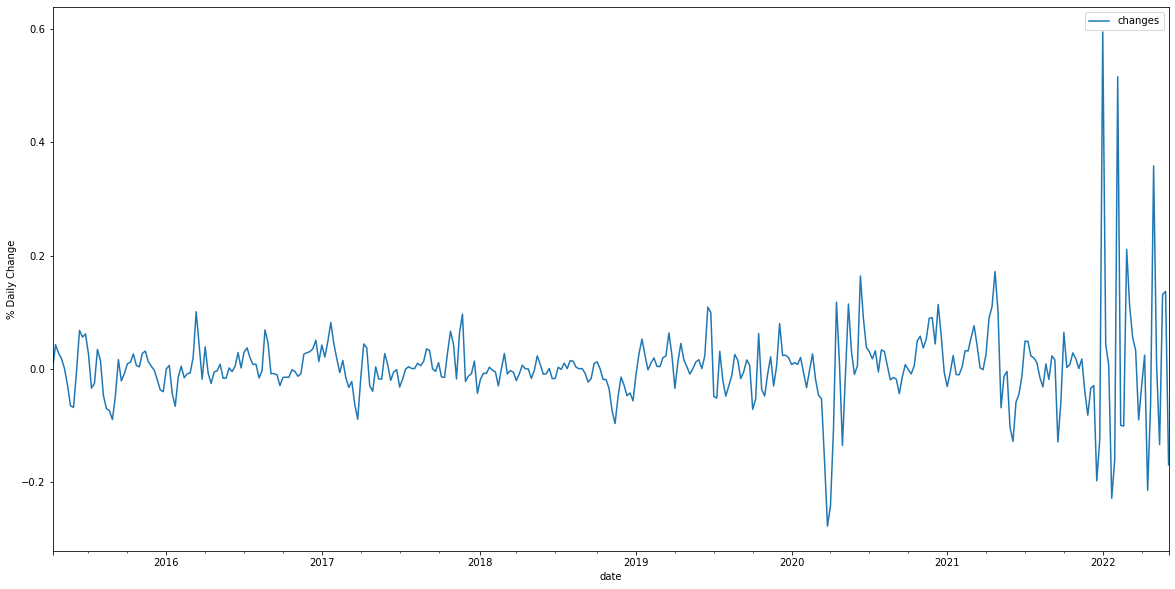

In [18]:
df.plot(figsize=(20,10))
plt.ylabel('% Daily Change')

## 4.0 Modeling

### 4.1 PyMC Model Specification

In [19]:
with pm.Model() as model:
    df_returns = pm.Data("changes", df["changes"], dims="date", export_index_as_coords=True)

    nu = pm.Exponential("nu", 0.1, testval=5.0)
    #nu = pm.Normal("nu", mu=2, sigma=4)

    sigma = pm.Exponential("sigma", 50, testval=0.1)
    #sigma = pm.Normal("sigma", mu=2, sigma=4)

    s = pm.GaussianRandomWalk("s", sigma=sigma, dims='date')

    volatility_process = pm.Deterministic(
        "volatility_process", pm.math.exp(-2 * s) ** 0.5, dims='date'
    )

    r= pm.StudentT("r", nu=nu, sigma=volatility_process, observed=df_returns, dims='date')

### 4.2 Fit Model: posterior Estimation

In [22]:
with model:
    trace = pm.sample(2000, init="adapt_diag", return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, s]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 129 seconds.


In [35]:
with model:
    trace.extend(pm.sample_posterior_predictive(trace))

In [36]:
trace

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

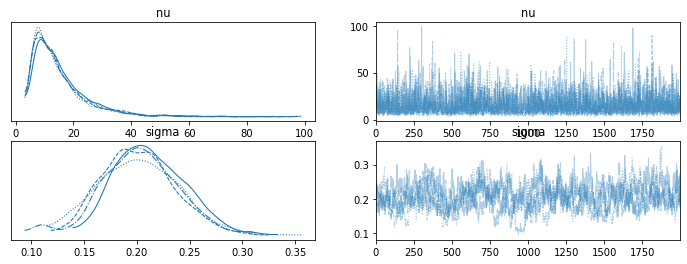

In [37]:
with model:
    az.plot_trace(trace, var_names=["nu","sigma"])

In [66]:
posterior = trace.posterior.stack(pooled_chain=('chain','draw'))
posterior_predictive = trace.posterior_predictive.stack(pooled_chain=("chain", "draw"))

In [67]:
posterior

<xarray.Dataset>
Dimensions:             (date: 374, pooled_chain: 8000)
Coordinates:
  * date                (date) object 2015-04-12T00:00:00+00:00 ... 2022-06-0...
  * pooled_chain        (pooled_chain) MultiIndex
  - chain               (pooled_chain) int64 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3
  - draw                (pooled_chain) int64 0 1 2 3 4 ... 1996 1997 1998 1999
Data variables:
    s                   (date, pooled_chain) float64 3.82 2.897 ... 1.75 2.273
    nu                  (pooled_chain) float64 27.17 23.49 17.79 ... 13.22 23.73
    sigma               (pooled_chain) float64 0.1934 0.1986 ... 0.2395 0.2233
    volatility_process  (date, pooled_chain) float64 0.02193 0.05517 ... 0.103
Attributes:
    created_at:                 2022-06-21T20:14:10.483970
    arviz_version:              0.12.1
    inference_library:          pymc
    inference_library_version:  4.0.1
    sampling_time:              129.28151154518127
    tuning_steps:               1000

Values for posterior predictive are E123 so something is off


Text(0.5, 1.0, 'Posterior Volatility')

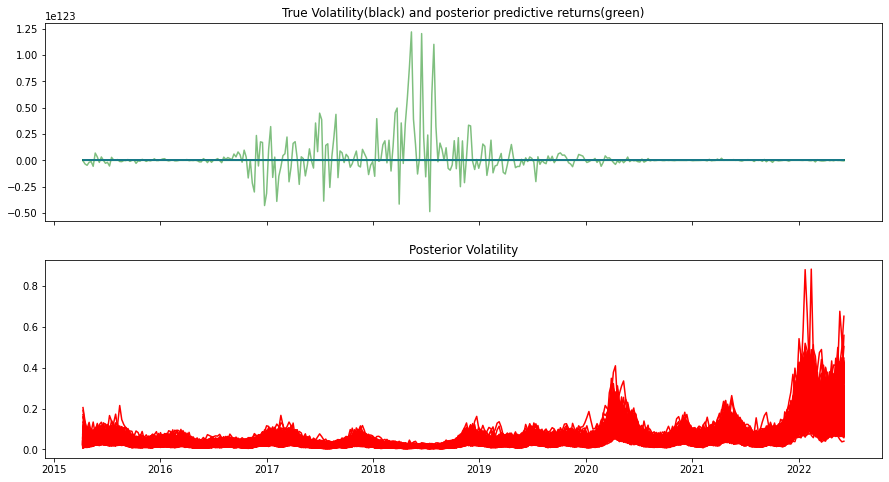

In [83]:
print('Values for posterior predictive are E123 so something is off')
fig, axes = plt.subplots(nrows=2, figsize=(15,8), sharex=True)
#df.plot(ax=axes[0], color='black')
axes[0].plot(df.index, df['changes'])
axes[0].plot(df.index,
    posterior_predictive['r'].isel(pooled_chain=slice(None,None,50)),
    "g", alpha = 0.5, zorder = -10)
axes[0].set_title("True Volatility(black) and posterior predictive returns(green)")

axes[1].plot(df.index, posterior['volatility_process'].isel(pooled_chain=slice(None,None,5)), "r")
axes[1].set_title('Posterior Volatility')
#plt.show()
#fig.savefig('TracePlot.jpg')

In [99]:
posterior['volatility_process'][:,:100]

<xarray.DataArray 'volatility_process' (date: 374, pooled_chain: 100)>
array([[0.02192511, 0.05516541, 0.03025686, ..., 0.02299703, 0.03941487,
        0.04365088],
       [0.02407757, 0.05733399, 0.03597948, ..., 0.02507513, 0.04161061,
        0.03480255],
       [0.02736649, 0.05115848, 0.03507812, ..., 0.02742125, 0.03470906,
        0.02373276],
       ...,
       [0.10410835, 0.24114021, 0.15960561, ..., 0.08517625, 0.20305733,
        0.10647854],
       [0.1159631 , 0.18014774, 0.20815688, ..., 0.08774918, 0.22989946,
        0.12426574],
       [0.11296077, 0.16200502, 0.27832454, ..., 0.10572038, 0.30724859,
        0.10198943]])
Coordinates:
  * date          (date) object 2015-04-12T00:00:00+00:00 ... 2022-06-05T00:0...
  * pooled_chain  (pooled_chain) MultiIndex
  - chain         (pooled_chain) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
  - draw          (pooled_chain) int64 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99

[Text(0.5, 1.0, 'Volatility Process'),
 Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Volatility')]

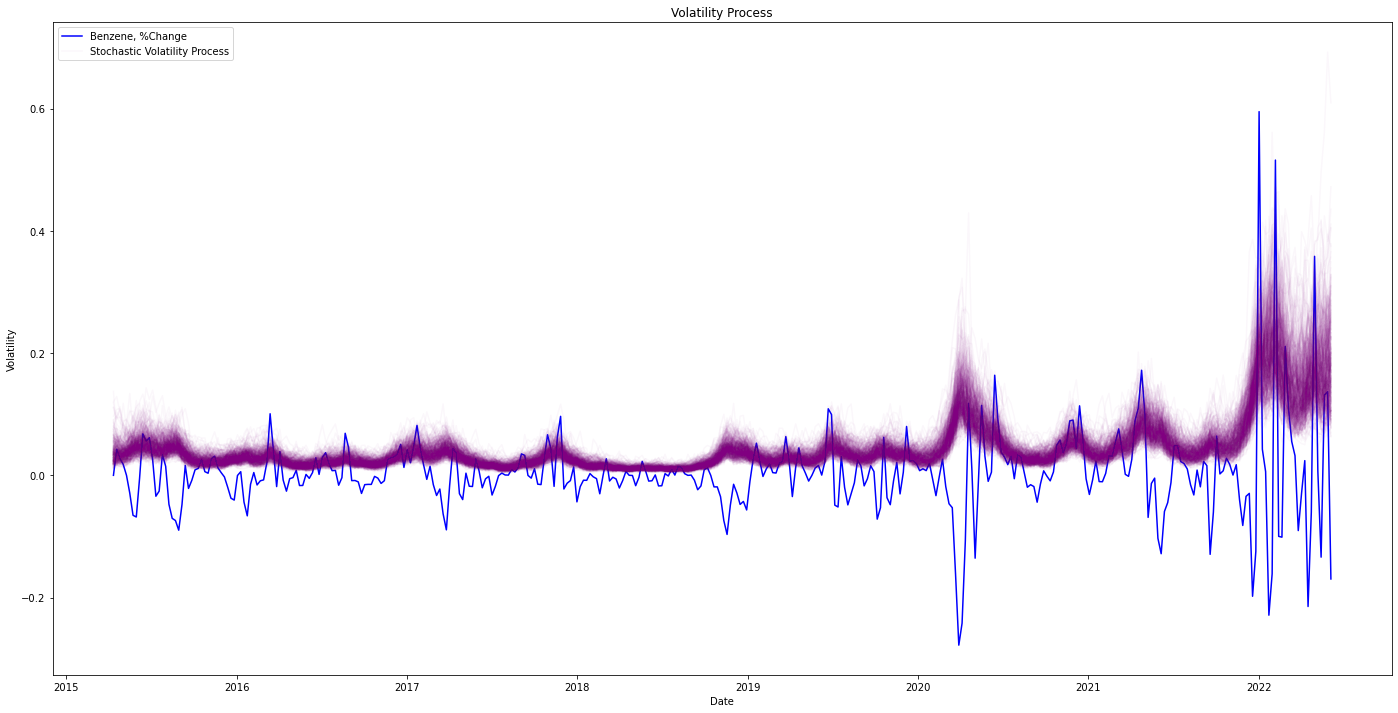

In [109]:
fig, ax = plt.subplots(figsize=(24, 12))
ax.plot(df.index, df.changes, color='blue')
ax.plot(df.index, posterior['volatility_process'][:,:500],"purple", alpha=0.03)
ax.legend(['Benzene, %Change', 'Stochastic Volatility Process'], loc='upper left')
ax.set(title='Volatility Process', xlabel='Date', ylabel='Volatility')

#### 4.2.2 Eigenvesting

https://srome.github.io/Eigenvesting-IV-Predicting-Stock-And-Portfolio-Returns-With-Bayesian-Statistics/

In [166]:
train = df[1/1/2015:12/31/2018]

TypeError: cannot do slice indexing on DatetimeIndex with these indexers [0.0004962779156327543] of type float

In [126]:
with pm.Model() as model:
    df_returns = pm.Data("changes", df["changes"], dims="date", export_index_as_coords=True)

    nu = pm.Exponential("nu", 0.1, testval=5.0)
    #nu = pm.Normal("nu", mu=2, sigma=4)

    mu = pm.Normal('mu', 0, testval = 0.1)

    sigma = pm.Exponential("sigma", 50, testval=0.1)
    #sigma = pm.Normal("sigma", mu=2, sigma=4)

    logs = pm.GaussianRandomWalk("logs", sigma=sigma, dims='date')

    volatility_process = pm.Deterministic(
        "volatility_process", 1/pm.math.exp(-2 * logs) ** 0.5, dims='date'
    )

    r= pm.StudentT("r", nu=nu, mu=mu, lam=volatility_process, observed=df_returns, dims='date')

In [161]:
with model:
    start = pm.find_MAP(vars=[logs])#, method=sp.optimize.fmin_l_bfgs_b)

with model:
    step = pm.NUTS(vars=[logs, mu, nu, sigma], gamma=0.25)#, scaling = start)#, gamma = 0.25)
    trace = pm.sample(100, step, start=start)

Only 100 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logs, mu, nu, sigma]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 111 seconds.
The acceptance probability does not match the target. It is 0.7148, but should be close to 0.8. Try to increase the number of tuning steps.


In [165]:
with model:
    az.plot_trace(trace), var_names=["nu","sigma",'logs','mu'])

SyntaxError: invalid syntax (2760540214.py, line 2)

# Documentation and Links

#### PyMC Github
* https://github.com/pymc-devs/pymc

#### Examples
* https://medium.com/nerd-for-tech/probabilistic-programming-using-pymc3-tesla-stock-stochastic-volatility-estimation-573f13a42fae